In [176]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import h5py

In [177]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import Tensor
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Reshape, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, UpSampling2D, GlobalMaxPooling2D, Conv2DTranspose
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.python.keras.utils import layer_utils
from tensorflow.keras.utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.callbacks import CSVLogger
import keras.models
from typing import List, Tuple
from time import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
!pip install TensorRT

In [178]:
h = h5py.File('new_reduced_data.h5', 'r')

In [179]:
glitches = h['new_glitches'][:]

In [180]:
glitch_labels = h['glitch_labels'][:]

In [181]:
# separating the instances
norm_data = h['new_clean'][:]
norm_labels = h['clean_labels'][:]
anom1_data = h['new_whistle'][:]
anom1_labels = h['whistle_labels'][:]
anom2_data = h['new_tomte'][:]
anom2_labels = h['tomte_labels'][:]
anom3_data = h['new_sclight'][:]
anom3_labels = h['sclight_labels'][:]

In [182]:
def convolution_1d(X: tf.Tensor, filters: List[int], kernel: Tuple[int,int], s: Tuple[int,int], padding:str, name: str) -> tf.Tensor:
    f1 = filters
    
    X = Conv2D(filters=f1, kernel_size=kernel, strides=s, padding=padding, name=name)(X)
    X = Activation('relu')(X)
    
    return X

In [183]:
def deconvolution_1d(X: tf.Tensor, filters: List[int], kernel: Tuple[int,int], s: Tuple[int,int], padding:str, name: str) -> tf.Tensor:
    f1 = filters
    
    X = Conv2DTranspose(filters=f1, kernel_size=kernel, strides=s, padding=padding, name=name)(X)
    X = Activation('relu')(X)
    
    return X

In [193]:
def Net(input_size: Tuple[int,int,int]) -> Model:
    X_input1 = Input(input_size)
    
    X_input2 = X_input1*1
    
    tensor_shape = tf.shape(X_input2)
    
    X_input2 = tf.slice(X_input2, [0, 0, 0, 0], [-1, tensor_shape[1] - 1, -1, -1])
    
    X = tf.concat((X_input1, X_input2), axis=1)
    
    X = convolution_1d(X, filters=120, kernel=(X_input1.shape[1],1), s=(1, 1), padding='valid', name='convolution_1')
    
    X = convolution_1d(X, filters=150, kernel=(5,1), s=(2, 1), padding='same', name='convolution_2')
    
    X = convolution_1d(X, filters=150, kernel=(5,1), s=(5, 1), padding='same', name='convolution_3')
    
    X = deconvolution_1d(X, filters=120, kernel=(5,1), s=(5, 1), padding='same', name='deconvolution_1')
    
    X = deconvolution_1d(X, filters=1, kernel=(5,1), s=(2, 1), padding='same', name='deconvolution_2')
        
    # Create model
    model = Model(inputs=X_input1, outputs=X, name='ConvAutoEnc')

    return model

In [194]:
model = Net(input_size = (50, 56, 1))

In [195]:
model.summary()

Model: "ConvAutoEnc"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 50, 56, 1)]  0           []                               
                                                                                                  
 tf.math.multiply_23 (TFOpLambd  (None, 50, 56, 1)   0           ['input_20[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.compat.v1.shape_23 (TFOpLam  (4,)                0           ['tf.math.multiply_23[0][0]']    
 bda)                                                                                             
                                                                                        

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
csv_logger = CSVLogger('training.log')
t0 = time()
history = model.fit(glitches, glitches, batch_size=168, epochs=500, callbacks=[csv_logger])
print('Training time: ', time() - t0)

In [197]:
prediction1 = model.predict(anom1_data)
prediction1 = tf.squeeze(prediction1)
prediction1_loss = tf.keras.losses.mae(prediction1, anom1_data)
rec_err1 = np.sum(prediction1_loss, axis=1)

28/28 [==============================] - 1s 33ms/step


In [198]:
prediction2 = model.predict(anom2_data)
prediction2 = tf.squeeze(prediction2)
prediction2_loss = tf.keras.losses.mae(prediction2, anom2_data)
rec_err2 = np.sum(prediction2_loss, axis=1)

28/28 [==============================] - 1s 32ms/step


In [199]:
prediction3 = model.predict(anom3_data)
prediction3 = tf.squeeze(prediction3)
prediction3_loss = tf.keras.losses.mae(prediction3, anom3_data)
rec_err3 = np.sum(prediction3_loss, axis=1)

28/28 [==============================] - 1s 34ms/step


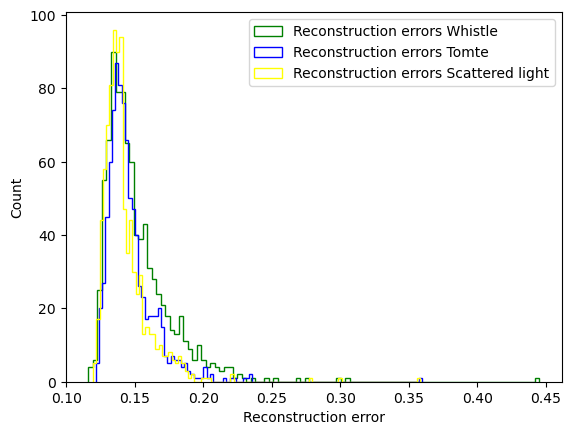

In [201]:
n1 = plt.hist(rec_err1, bins=100, label='Reconstruction errors Whistle', color='green', histtype='step')
n2 = plt.hist(rec_err2, bins=100, label='Reconstruction errors Tomte', color='blue', histtype='step')
n3 = plt.hist(rec_err3, bins=100, label='Reconstruction errors Scattered light', color='yellow', histtype='step')
plt.legend()
plt.ylabel('Count')
plt.xlabel('Reconstruction error')
#plt.xlim([9,15])
plt.show()

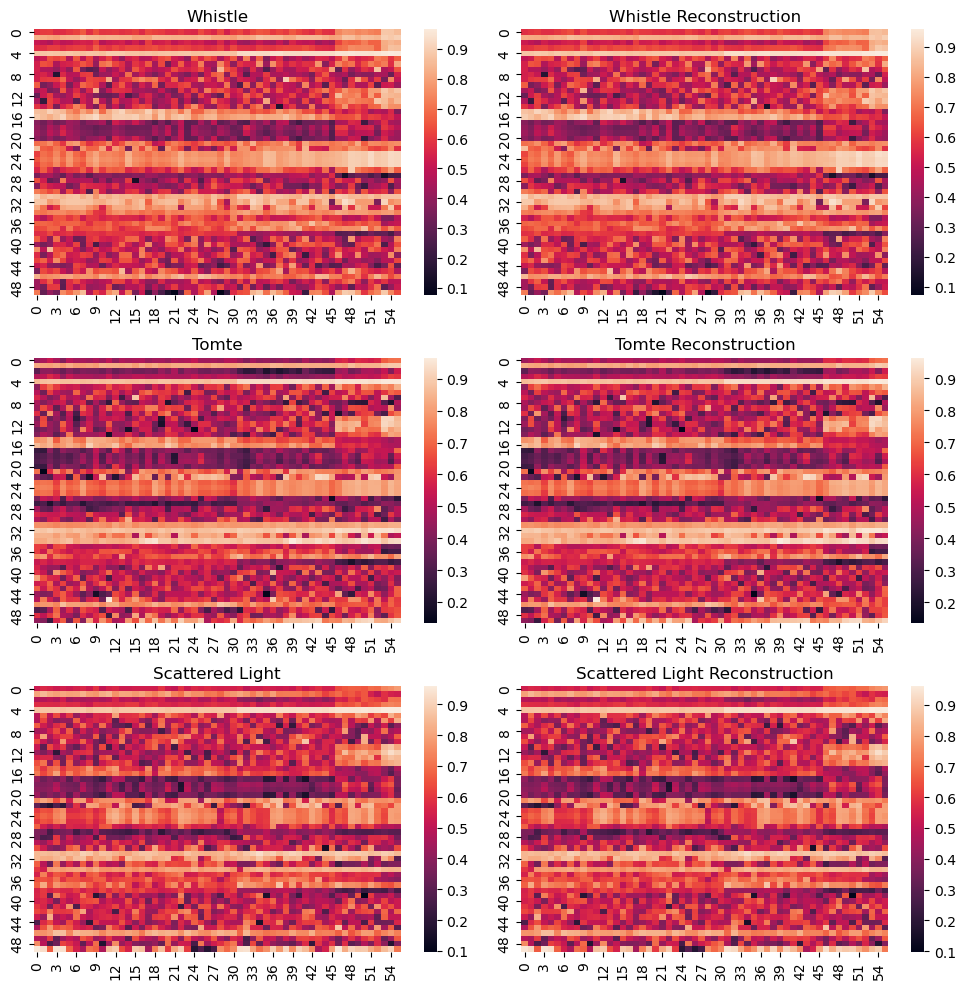

In [202]:
fig = plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.title('Whistle')
sns.heatmap(anom1_data[1])
plt.subplot(3,2,2)
plt.title('Whistle Reconstruction')
sns.heatmap(prediction1[1])

plt.subplot(3,2,3)
plt.title('Tomte')
sns.heatmap(anom2_data[1])
plt.subplot(3,2,4)
plt.title('Tomte Reconstruction')
sns.heatmap(prediction2[1])

plt.subplot(3,2,5)
plt.title('Scattered Light')
sns.heatmap(anom3_data[1])
plt.subplot(3,2,6)
plt.title('Scattered Light Reconstruction')
sns.heatmap(prediction3[1])

fig.tight_layout()
fig.show()

In [205]:
# we can now extract the features of the data
feature_model = Model(inputs=model.input, outputs=model.get_layer(name='convolution_3').output)
features = feature_model.predict(glitches)
print('feature shape=', features.shape)

84/84 [==============================] - 2s 25ms/step
feature shape= (2688, 5, 56, 150)


In [206]:
features1 = np.reshape(features, newshape=(features.shape[0], -1))

In [207]:
# let us visualize
tSNE = TSNE(n_components=2, learning_rate='auto')
X_tsne = tSNE.fit_transform(features1)

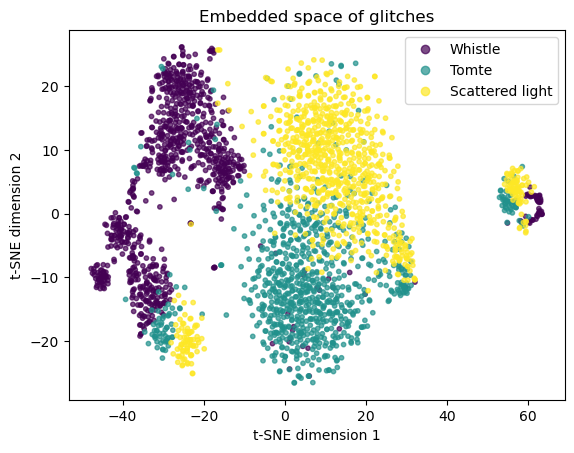

In [208]:
plot = plt.scatter(X_tsne[:,0], X_tsne[:,1], s=10, c=glitch_labels, alpha=0.7)
#plt.scatter(X_tsne[idxs[:],0], X_tsne[idxs[:],1], s=20, c='red')
plt.legend(handles=plot.legend_elements()[0], labels=['Whistle', 'Tomte', 'Scattered light'])
plt.ylabel('t-SNE dimension 2')
plt.xlabel('t-SNE dimension 1')
plt.title('Embedded space of glitches')
plt.show()